In [1]:
import numpy as np
import pandas as pd
df = pd.DataFrame
import pickle
import os
from copy import deepcopy
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms, models

import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import seaborn as sns

In [2]:
# device to train model on
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [3]:
adata = pickle.load(open('odata_NANDiterate.pkl','rb'))

# normalize X (per gene)
# scaler = StandardScaler()
# scaler.fit(adata.X)
# adata.X = scaler.transform(adata.X)


In [4]:
X = torch.tensor(adata.X[:,0:-9]).type(torch.float) # host gene transcriptomics (already log1p'd)

In [5]:
def MinMaxScale(arr,feature_range=(0,1)):
    scaler = MinMaxScaler(feature_range=feature_range)
    scaler.fit(arr)
    return scaler.transform(arr)

In [32]:
# continuous perturbations (circuit gene expression, time, IPTG_dose, Ara_dose)

time_ara_iptg_range = 5

pert = adata.X[:,-9:] # circuit genes (already log1p'd)
times = adata.obs.timepoint.astype(np.float32).values.reshape(-1,1)
times = MinMaxScale(times,feature_range=(0,time_ara_iptg_range))
adata.obs.timepoint = times
iptg = adata.obs.IPTG_concentration.astype(np.float32).values.reshape(-1,1) 
iptg = MinMaxScale(iptg,feature_range=(0,time_ara_iptg_range))
adata.obs.IPTG_concentration = iptg
ara = adata.obs.arabinose_concentration.astype(np.float32).values.reshape(-1,1) 
ara = MinMaxScale(ara,feature_range=(0,time_ara_iptg_range))
adata.obs.arabinose_concentration = ara
pert = np.concatenate((pert,times,iptg,ara),axis=1)
pert = torch.tensor(pert).type(torch.float)

pert_inds = [[0,1,2,3,4,5,6,7,8],[9],[10,11]]

P = pert[:,pert_inds[0]] # torch tensor with synthetic gene expressions
T = pert[:,pert_inds[1]] # torch tensor with time
D = pert[:,pert_inds[2]] # torch tensor with dose (IPTG/Ara)

In [7]:
# discrete covariates (wild-type, synthetic genome, synthetic plasmid)
# can later possibly expand to individual sub-strains, 
# though this would defeat the purpose of modeling the circuit gene expressions

In [8]:
class Encoder(nn.Module):
    '''
    Encodes gene expression vectors to latent space of dim hidden_dims[-1]
    '''
    def __init__(self, input_dim, hidden_dims):
        super(Encoder, self).__init__()
        
        self.fc1 = nn.Linear(input_dim, hidden_dims[0])
        self.fc2 = nn.Linear(hidden_dims[0], hidden_dims[0])
        self.fc3 = nn.Linear(hidden_dims[0], hidden_dims[1])
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
    
class Decoder(nn.Module):
    '''
    Decodes gene expression latent vectors back to dim output_dim
    '''
    def __init__(self, output_dim, hidden_dims):
        super(Decoder, self).__init__()
        
        self.fc1 = nn.Linear(hidden_dims[1], hidden_dims[0])
        self.fc2 = nn.Linear(hidden_dims[0], hidden_dims[0])
        self.fc3 = nn.Linear(hidden_dims[0], output_dim)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
    
class PertEncoder(nn.Module):
    '''
    We now want to add in the effect of the perturbations from synthetic genes on the basal state. 
    Almost analogous to sDMD, we will do this using a nonlinear function and assume 
    that the perturbation impact is linear in the latent space. 
    '''
    def __init__(self, pert_dim, basal_dim):
        super(PertEncoder, self).__init__()
        
        self.fc1 = nn.Linear(pert_dim, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, basal_dim)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    
class TimeEncoder(nn.Module):
    '''
    We now want to add in the effect of the perturbations from synthetic genes on the basal state. 
    Almost analogous to sDMD, we will do this using a nonlinear function and assume 
    that the perturbation impact is linear in the latent space. 
    '''
    def __init__(self, pert_dim, basal_dim):
        super(TimeEncoder, self).__init__()
        
        self.fc1 = nn.Linear(pert_dim, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, basal_dim)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


class DoseEncoder(nn.Module):
    '''
    We now want to add in the effect of the perturbations from synthetic genes on the basal state. 
    Almost analogous to sDMD, we will do this using a nonlinear function and assume 
    that the perturbation impact is linear in the latent space. 
    '''
    def __init__(self, pert_dim, basal_dim):
        super(DoseEncoder, self).__init__()
        
        self.fc1 = nn.Linear(pert_dim, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, basal_dim)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
    
class PertDecoder(nn.Module):
    '''
    Map the encoded perturbations back to the original space. This allows us to 
    interpolate in perturbation latent space and then generate new hypotheses. 
    This network can be re-used for all perturbations (synthetic genes, dose, time)
    '''
    def __init__(self, pert_dim, basal_dim):
        super(PertDecoder, self).__init__()
        
        self.fc1 = nn.Linear(basal_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, pert_dim)
        
    def forward(self, x):
        x = F.relu(self.fc1(x)) 
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))  # want positive values
        return x
    
    
class Autoencoder(nn.Module):
    '''
    Gene expression autoencoder + perturbation in latent space. 
    '''
    
    def __init__(self, input_dim, hidden_dims, pert_dims):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder(input_dim, hidden_dims)
        self.decoder = Decoder(input_dim, hidden_dims)
        self.pertencoder = PertEncoder(pert_dims[0], hidden_dims[-1])
        self.timeencoder = TimeEncoder(pert_dims[1], hidden_dims[-1])
        self.doseencoder = TimeEncoder(pert_dims[2], hidden_dims[-1])
        
    def forward(self, x, p, t, d): # p is the vector of syn gene perturbations, t is time, d is dose
        x = self.encoder(x)
        x = x + self.pertencoder(p) + self.timeencoder(t) + self.doseencoder(d)
        x = self.decoder(x)
        return x
    
    
class Discriminator(nn.Module):
    '''
    Takes in basal state and uses it to predict the continuous perturbation vector. 
    The goal is to have the discriminator do no better than guessing, meaning that the 
    basal state contains little to no information about the perturbations. 
    '''
    def __init__(self, input_dim, pert_dim):
        super(Discriminator, self).__init__()
        
        self.fc1 = nn.Linear(input_dim, 16)
        self.fc2 = nn.Linear(16, pert_dim)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
        

In [49]:
torch.manual_seed(42);

input_dim = X.shape[1]
p_dim = P.shape[1] # synthetic gene perturbation dim
t_dim = T.shape[1] 
d_dim = D.shape[1] # dose dimension (not discriminator)
hidden_dim = 128
basal_dim = 2

autoenc = Autoencoder(input_dim, [hidden_dim, basal_dim], [p_dim, t_dim, d_dim])
discrim = Discriminator(basal_dim, p_dim+t_dim+d_dim) # tries to predict each perturbations simultaneously
pdec = PertDecoder(p_dim, basal_dim) # synthetic gene decoder
tdec = PertDecoder(t_dim, basal_dim) # time decoder
ddec = PertDecoder(d_dim, basal_dim) # dose decoder

autoenc.to(device)
discrim.to(device)
pdec.to(device)
tdec.to(device)
ddec.to(device)

criterion = nn.MSELoss()

autoenc_optimizer = torch.optim.Adadelta(autoenc.parameters(), lr=1.1, weight_decay=1e-5)
discrim_optimizer = torch.optim.Adam(discrim.parameters(), weight_decay=0.0)
pdec_optimizer = torch.optim.Adadelta(pdec.parameters(), lr=1.1, weight_decay=1e-5)
tdec_optimizer = torch.optim.Adadelta(tdec.parameters(), lr=1.1, weight_decay=1e-5)
ddec_optimizer = torch.optim.Adadelta(ddec.parameters(), lr=1.1, weight_decay=1e-5)

In [69]:
NUM_EPOCHS = 5000
lam = 0.001
BATCH_SIZE = 128
loss = {'recon':[],'discrim':[],'p_recon':[],'t_recon':[],'d_recon':[]}
for epoch in range(NUM_EPOCHS):
    
    permutation = torch.randperm(X.shape[0])
    running_loss_x = 0.0
    running_loss_d = 0.0
    running_loss_p = 0.0
    running_loss_t = 0.0
    running_loss_dose = 0.0
    
    for cnt, jj in enumerate(range(0, X.shape[0], BATCH_SIZE)):

        batch_inds = permutation[jj:jj+BATCH_SIZE] # grab batch 
        batch_x = X[batch_inds].to(device)
        batch_p = P[batch_inds].to(device) 
        batch_t = T[batch_inds].to(device)
        batch_d = D[batch_inds].to(device) 
        batch_all_perts = torch.cat((batch_p, batch_t, batch_d),dim=1) # vector of all perts for discriminator loss
        
        # train the discriminator
        discrim_optimizer.zero_grad()
        
        batch_z = autoenc.encoder(batch_x) # latent x
        p_hat = discrim(batch_z) # prediction of all perts by discriminator
        discrim_loss = criterion(p_hat, batch_all_perts)  
        discrim_loss.backward(retain_graph=True) # retain graph to use the loss as a reward for autoencoder         

        # train the autoencoder, pertencoder, timeencoder, doseencoder
        autoenc_optimizer.zero_grad()

        X_hat = autoenc(batch_x, batch_p, batch_t, batch_d)
        autoenc_loss = criterion(X_hat, batch_x)  - lam * discrim_loss
        autoenc_loss.backward()

        discrim_optimizer.step()
        autoenc_optimizer.step()
        
        # train the pertdecoder, timedecoder, dosedecoder
        pdec_optimizer.zero_grad()
        tdec_optimizer.zero_grad()
        ddec_optimizer.zero_grad()
        
        p_latent = autoenc.pertencoder(batch_p)
        p_hat = pdec(p_latent)
        pdec_loss = criterion(p_hat, batch_p)
        pdec_loss.backward()
        pdec_optimizer.step()
        
        t_latent = autoenc.timeencoder(batch_t)
        t_hat = tdec(t_latent)
        tdec_loss = criterion(t_hat, batch_t)
        tdec_loss.backward()
        tdec_optimizer.step()
        
        d_latent = autoenc.doseencoder(batch_d)
        d_hat = ddec(d_latent)
        ddec_loss = criterion(d_hat, batch_d)
        ddec_loss.backward()
        ddec_optimizer.step()

        with torch.no_grad():
            running_loss_x += autoenc_loss.item()
            running_loss_d += discrim_loss.item()
            running_loss_p += pdec_loss.item()
            running_loss_t += tdec_loss.item()
            running_loss_dose += ddec_loss.item()
            
    if epoch % (NUM_EPOCHS*0.05) == 0: 
        loss['recon'].append( running_loss_x/(cnt+1) )
        loss['discrim'].append( running_loss_d/(cnt+1) )
        loss['p_recon'].append( running_loss_p/(cnt+1) )
        loss['t_recon'].append( running_loss_t/(cnt+1) )
        loss['d_recon'].append( running_loss_dose/(cnt+1) )
        print( f'EPOCH: {epoch}, D_LOSS: {running_loss_d/(cnt+1):.4f}, X_LOSS: {running_loss_x/(cnt+1):.4f}, '
                  f'P_LOSS: {running_loss_p/(cnt+1):.4f}, T_LOSS: {running_loss_t/(cnt+1):.4f}, '
                  f'DOSE_LOSS: {running_loss_dose/(cnt+1):.4f}' )

EPOCH: 0, D_LOSS: 8.3177, X_LOSS: 0.0707, P_LOSS: 2.5900, T_LOSS: 0.0001, DOSE_LOSS: 0.0858
EPOCH: 250, D_LOSS: 8.3026, X_LOSS: 0.0645, P_LOSS: 2.5430, T_LOSS: 0.0001, DOSE_LOSS: 0.0707
EPOCH: 500, D_LOSS: 8.3324, X_LOSS: 0.0704, P_LOSS: 2.6018, T_LOSS: 0.0000, DOSE_LOSS: 0.0700
EPOCH: 750, D_LOSS: 8.3162, X_LOSS: 0.0724, P_LOSS: 2.4529, T_LOSS: 0.0001, DOSE_LOSS: 0.0720
EPOCH: 1000, D_LOSS: 8.3209, X_LOSS: 0.0717, P_LOSS: 2.7718, T_LOSS: 0.0013, DOSE_LOSS: 0.0707
EPOCH: 1250, D_LOSS: 8.3247, X_LOSS: 0.0726, P_LOSS: 2.4341, T_LOSS: 0.0003, DOSE_LOSS: 0.0759
EPOCH: 1500, D_LOSS: 8.3079, X_LOSS: 0.0662, P_LOSS: 2.8100, T_LOSS: 0.0000, DOSE_LOSS: 0.0699
EPOCH: 1750, D_LOSS: 8.3145, X_LOSS: 0.0625, P_LOSS: 2.6219, T_LOSS: 0.0000, DOSE_LOSS: 0.0727
EPOCH: 2000, D_LOSS: 8.3091, X_LOSS: 0.0643, P_LOSS: 2.7110, T_LOSS: 0.0001, DOSE_LOSS: 0.0723
EPOCH: 2250, D_LOSS: 8.3172, X_LOSS: 0.0697, P_LOSS: 2.8733, T_LOSS: 0.0000, DOSE_LOSS: 0.0701
EPOCH: 2500, D_LOSS: 8.3262, X_LOSS: 0.0678, P_LOSS: 2.9

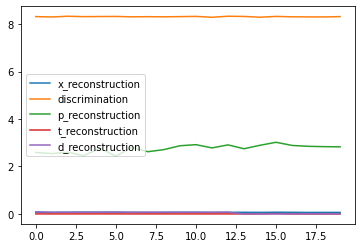

0.8321737385218965
0.08305379284178031
0.7681787024875708
0.9999999496168871
0.9999788772443072


In [70]:
plt.plot(loss['recon'],label='x_reconstruction')
plt.plot(loss['discrim'],label='discrimination')
plt.plot(loss['p_recon'],label='p_reconstruction')
plt.plot(loss['t_recon'],label='t_reconstruction')
plt.plot(loss['d_recon'],label='d_reconstruction')
plt.legend()
plt.show()

autoenc.eval()
discrim.eval()
with torch.no_grad():
    
    X_hat = autoenc(X.to(device), P.to(device), T.to(device), D.to(device)).cpu().numpy()
    print(r2_score(X.numpy(),X_hat))

    p_hat = discrim(autoenc.encoder(X.to(device))).cpu().numpy()
    print(r2_score(pert.numpy(),p_hat))
    
    p_hat = pdec(autoenc.pertencoder(P.to(device))).cpu().numpy()
    print(r2_score(P.numpy(),p_hat))
    
    t_hat = tdec(autoenc.timeencoder(T.to(device))).cpu().numpy()
    print(r2_score(T.numpy(),t_hat))
    
    d_hat = ddec(autoenc.doseencoder(D.to(device))).cpu().numpy()
    print(r2_score(D.numpy(),d_hat))
    

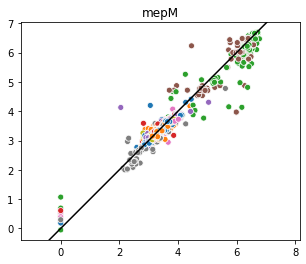

In [71]:
kk = np.random.randint(0,X.shape[1])
kk = adata.var_names.tolist().index('mepM')
fig, ax = plt.subplots(figsize=(5,4))
ax.set_title(adata.var.index.tolist()[kk])
sns.scatterplot(x=X.numpy()[:,kk],
                y=X_hat[:,kk],
                hue=adata.obs.strain,
                ax=ax,
                legend=False)
ax.axline((0, 0), slope=1, color='k',)
plt.axis('equal')
plt.show()

In [72]:
autoenc.eval() 
X_proj = autoenc.encoder(X.to(device)).cpu().detach().numpy()

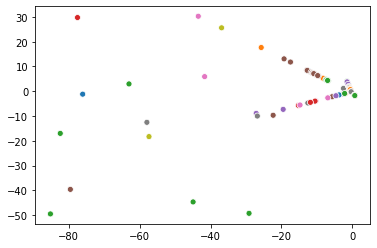

In [73]:
fig, ax = plt.subplots(1,1,figsize=(6,4),sharex=True,sharey=True)
sns.scatterplot(x=X_proj[:,0],y=X_proj[:,1],hue=adata.obs.strain,ax=ax,legend=False)
plt.show()

In [74]:
### Circuit gene impact on host ###

# grab an example
indices = np.nonzero( ( (adata.obs.strain.isin(['NAND_Circuit'])) & 
            (adata.obs.IPTG_concentration.isin([0.0])) &
            (adata.obs.arabinose_concentration.isin([0.0])) ).values )[0].tolist()
bdata = adata[indices].copy()
print(bdata)

# grab an example
w_indices = np.nonzero( ( (adata.obs.strain.isin(['wild-type'])) & 
            (adata.obs.IPTG_concentration.isin([0.0])) &
            (adata.obs.arabinose_concentration.isin([0.0])) ).values )[0].tolist()
wdata = adata[w_indices].copy()
print(wdata)

AnnData object with n_obs × n_vars = 28 × 4104
    obs: 'sample_id', 'timepoint', 'strain', 'temperature', 'replicate', 'arabinose_concentration', 'arabinose_unit', 'IPTG_concentration', 'IPTG_unit', 'strain_input_state', 'input_state', 'strain1'
    uns: 'log1p'
AnnData object with n_obs × n_vars = 28 × 4104
    obs: 'sample_id', 'timepoint', 'strain', 'temperature', 'replicate', 'arabinose_concentration', 'arabinose_unit', 'IPTG_concentration', 'IPTG_unit', 'strain_input_state', 'input_state', 'strain1'
    uns: 'log1p'


In [75]:
pert_b = np.concatenate(( bdata.X[:,-9:],
                 bdata.obs.timepoint.values.reshape(-1,1),
                 bdata.obs.IPTG_concentration.values.reshape(-1,1),
                 bdata.obs.arabinose_concentration.values.reshape(-1,1) ),axis=1)

pert_b_cf = deepcopy(pert_b)

# counterfactually change KanR expression to see what would happen to synthetic cell state genes
# inds_to_zero = [0,1,2,3]
inds_to_zero = [4,5,6,7,8]
# inds_to_zero = [4,7,8]
# inds_to_zero = [0,1,2,3,4,5,6,7,8]
frac2rmv = 1
pert_b_cf[:,inds_to_zero] = pert_b_cf[:,inds_to_zero] - frac2rmv*pert_b_cf[:,inds_to_zero]

# wild-type 
pert_w = np.concatenate(( wdata.X[:,-9:],
                 wdata.obs.timepoint.values.reshape(-1,1),
                 wdata.obs.IPTG_concentration.values.reshape(-1,1),
                 wdata.obs.arabinose_concentration.values.reshape(-1,1) ),axis=1)

pert_b = torch.tensor(pert_b)
pert_b_cf = torch.tensor(pert_b_cf)
pert_w = torch.tensor(pert_w)

In [76]:
autoenc.eval()
X_hat = autoenc(X[indices].to(device), 
                pert_b[:,pert_inds[0]].to(device),
                pert_b[:,pert_inds[1]].to(device), 
                pert_b[:,pert_inds[2]].to(device)).cpu().detach().numpy()
X_hat_cf = autoenc(X[indices].to(device), 
                   pert_b_cf[:,pert_inds[0]].to(device),
                   pert_b_cf[:,pert_inds[1]].to(device),
                   pert_b_cf[:,pert_inds[2]].to(device)).cpu().detach().numpy()
X_hat_w = autoenc(X[w_indices].to(device), 
                pert_w[:,pert_inds[0]].to(device),
                pert_w[:,pert_inds[1]].to(device), 
                pert_w[:,pert_inds[2]].to(device)).cpu().detach().numpy()

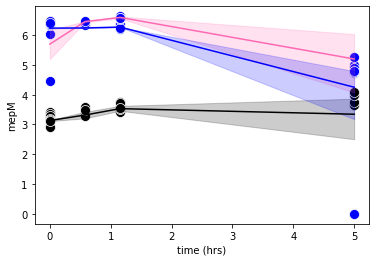

In [77]:
this_gene = 'mepM'
this_ind = adata.var_names.tolist().index(this_gene)
plt.figure(figsize=(6,4))
sns.scatterplot(x = bdata.obs.timepoint.tolist(),
                y = bdata[:,this_gene].X.toarray().reshape(-1),
                s = 100, legend = False, color='k',)

sns.scatterplot(x = wdata.obs.timepoint.tolist(),
                y = wdata[:,this_gene].X.toarray().reshape(-1),
                s = 100, legend = False, color='b',)

sns.lineplot(x=pert_b[:,-3],
             y=X_hat[:,this_ind],
             color='k')

sns.lineplot(x=pert_b_cf[:,-3],
             y=X_hat_cf[:,this_ind],
             color='hotpink')

sns.lineplot(x=pert_w[:,-3],
             y=X_hat_w[:,this_ind],
             color='b')

# plt.ylim(3.5,9.25)
plt.ylabel(this_gene)
plt.xlabel('time (hrs)')
plt.show()

In [78]:
### IPTG dose response ###

# grab an example
indices = np.nonzero( ( (adata.obs.strain.isin(['wild-type'])) & 
            (adata.obs.IPTG_concentration.isin([0.0])) &
            (adata.obs.arabinose_concentration.isin([0.0])) ).values )[0].tolist()
bdata = adata[indices].copy()
print(bdata)

# grab an example
w_indices = np.nonzero( ( (adata.obs.strain.isin(['wild-type'])) & 
            (adata.obs.IPTG_concentration.isin([adata.obs.IPTG_concentration.unique()[2]])) &
            (adata.obs.arabinose_concentration.isin([0.0])) ).values )[0].tolist()
wdata = adata[w_indices].copy()
print(wdata)

AnnData object with n_obs × n_vars = 28 × 4104
    obs: 'sample_id', 'timepoint', 'strain', 'temperature', 'replicate', 'arabinose_concentration', 'arabinose_unit', 'IPTG_concentration', 'IPTG_unit', 'strain_input_state', 'input_state', 'strain1'
    uns: 'log1p'
AnnData object with n_obs × n_vars = 14 × 4104
    obs: 'sample_id', 'timepoint', 'strain', 'temperature', 'replicate', 'arabinose_concentration', 'arabinose_unit', 'IPTG_concentration', 'IPTG_unit', 'strain_input_state', 'input_state', 'strain1'
    uns: 'log1p'


In [83]:
pert_b = np.concatenate(( bdata.X[:,-9:],
                 bdata.obs.timepoint.values.reshape(-1,1),
                 bdata.obs.IPTG_concentration.values.reshape(-1,1),
                 bdata.obs.arabinose_concentration.values.reshape(-1,1) ),axis=1)

pert_b_cf = deepcopy(pert_b)

# counterfactually change IPTG dose 
inds_to_change = [-2]
pert_b_cf[:,inds_to_change] = pert_b_cf[:,inds_to_change] + 5

# wild-type 
pert_w = np.concatenate(( wdata.X[:,-9:],
                 wdata.obs.timepoint.values.reshape(-1,1),
                 wdata.obs.IPTG_concentration.values.reshape(-1,1),
                 wdata.obs.arabinose_concentration.values.reshape(-1,1) ),axis=1)

pert_b = torch.tensor(pert_b)
pert_b_cf = torch.tensor(pert_b_cf)
pert_w = torch.tensor(pert_w)

In [84]:
autoenc.eval()
X_hat = autoenc(X[indices].to(device), 
                pert_b[:,pert_inds[0]].to(device),
                pert_b[:,pert_inds[1]].to(device), 
                pert_b[:,pert_inds[2]].to(device)).cpu().detach().numpy()
X_hat_cf = autoenc(X[indices].to(device), 
                   pert_b_cf[:,pert_inds[0]].to(device),
                   pert_b_cf[:,pert_inds[1]].to(device),
                   pert_b_cf[:,pert_inds[2]].to(device)).cpu().detach().numpy()
X_hat_w = autoenc(X[w_indices].to(device), 
                pert_w[:,pert_inds[0]].to(device),
                pert_w[:,pert_inds[1]].to(device), 
                pert_w[:,pert_inds[2]].to(device)).cpu().detach().numpy()

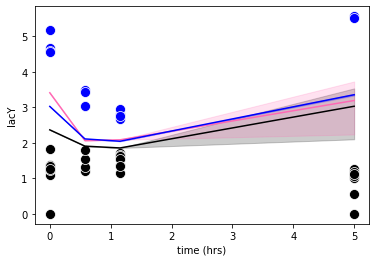

In [85]:
this_gene = 'lacY'
this_ind = adata.var_names.tolist().index(this_gene)
plt.figure(figsize=(6,4))
sns.scatterplot(x = bdata.obs.timepoint.tolist(),
                y = bdata[:,this_gene].X.toarray().reshape(-1),
                s = 100, legend = False, color='k',)

sns.scatterplot(x = wdata.obs.timepoint.tolist(),
                y = wdata[:,this_gene].X.toarray().reshape(-1),
                s = 100, legend = False, color='b',)

sns.lineplot(x=pert_b[:,-3],
             y=X_hat[:,this_ind],
             color='k')

sns.lineplot(x=pert_b_cf[:,-3],
             y=X_hat_cf[:,this_ind],
             color='hotpink')

sns.lineplot(x=pert_w[:,-3],
             y=X_hat_w[:,this_ind],
             color='b')

# plt.ylim(3.5,9.25)
plt.ylabel(this_gene)
plt.xlabel('time (hrs)')
plt.show()

In [86]:
### Pertubation embeddings ###
autoenc.eval()
latent_pert = autoenc.pertencoder(P.to(device)).detach().cpu().numpy()

if basal_dim > 2: 
    pca = PCA(n_components=2)
    pca.fit(latent_pert)
    pert_proj = pca.fit_transform(latent_pert)
#     latent_pert_hat = pca.inverse_transform(pert_proj)

In [87]:
strain2num = {strain:ii for ii, strain in enumerate(adata.obs.strain.unique().tolist())}
strainNumList = [strain2num[strain] for strain in adata.obs.strain.tolist()]

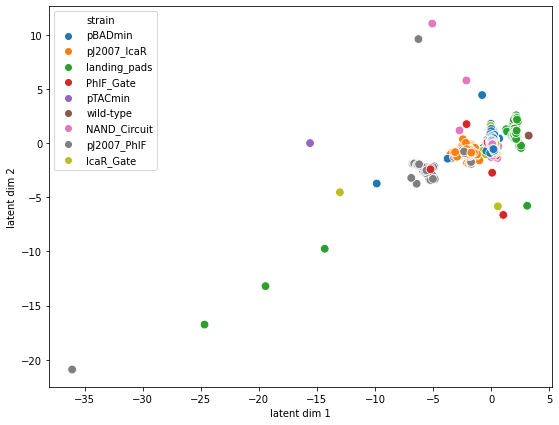

In [88]:
plt.figure(figsize=(9,7))
g = sns.scatterplot(x=latent_pert[:,0],y=latent_pert[:,1],hue=adata.obs.strain,s=75)
# sns.scatterplot(x=[-7.75],y=[3.375],color='r',s=125,edgecolor='k',linewidth=2,zorder=-1,alpha=0.4)
plt.xlabel('latent dim 1')
plt.ylabel('latent dim 2')
plt.show()

In [140]:
### Generate a pt in perturbation latent space, use it to perturb a gene expression basal state ###
# Can use this approach to determine how far from wild-type we can go before dysregulating mepM. 
# Can give a quantitative value on mepM levels for different levels of 
autoenc.eval()
pdec.eval()
tdec.eval()
ddec.eval()

# generation of a latent synthetic gene perturbation
gen_latent_pert = torch.tensor([[-6,4,4,4,4]]).type(torch.float)
# decode perturbation
gen_pert = pertdec(gen_latent_pert.to(device))


In [141]:
gen_pert

tensor([[ 0.0000,  0.0000,  1.0298,  3.4002,  0.0000, 12.0730, 24.0814, 13.8515,
         39.7586,  4.5785, 18.7735, 20.1455]], device='cuda:0',
       grad_fn=<ReluBackward0>)

In [83]:
### Generate a grid of points in perturbation latent space ###
### Decode all these pts and plot heatmaps of the values of every perturbative element! ###

autoenc.eval()
pertdec.eval()

xarr = np.linspace(latent_pert[:,0].min(), latent_pert[:,0].max(), 250)
yarr = np.linspace(latent_pert[:,1].min(), latent_pert[:,1].max(), 250)

xx, yy = np.meshgrid(xarr, yarr)

res = {'Sensor_TetR':np.zeros(xx.shape),'Sensor_LacI':np.zeros(xx.shape),
       'Sensor_AraC':np.zeros(xx.shape),'Sensor_LuxR':np.zeros(xx.shape),
       'Circuit_PhlF':np.zeros(xx.shape),'KanR':np.zeros(xx.shape),
       'CmR':np.zeros(xx.shape),'YFP':np.zeros(xx.shape),
       'Circuit_IcaR':np.zeros(xx.shape),'time':np.zeros(xx.shape),
       'IPTG':np.zeros(xx.shape),'Ara':np.zeros(xx.shape)}

with torch.no_grad():
    for ii in range(xx.shape[0]):
        for jj in range(xx.shape[1]):
            # generation of a latent perturbation
            gen_latent_pert = torch.tensor([[xx[ii,jj],yy[ii,jj]]]).type(torch.float) 
            # decode perturbation
            gen_pert = pertdec(gen_latent_pert.to(device)).cpu().numpy().squeeze() 
            for kk in range(len(gen_pert)): # append to res
                res[list(res.keys())[kk]][ii,jj] = gen_pert[kk]
                

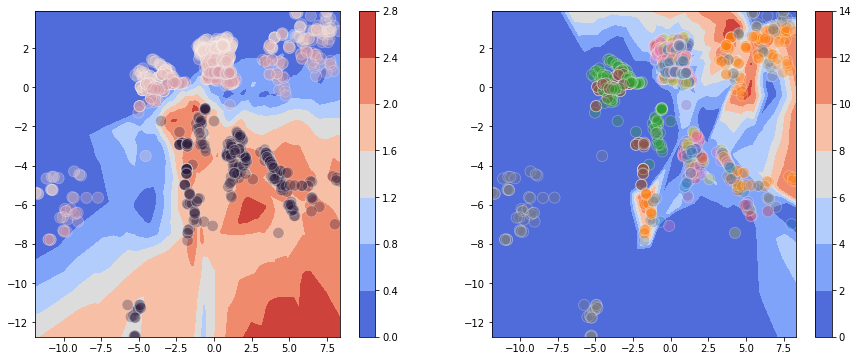

In [84]:
CMAP = 'coolwarm'

plt.figure(figsize=(15,6))
plt.subplot(121)
key2plot = 'time'
if key2plot == 'time':
    adatakey = 'timepoint'
elif key2plot == 'IPTG':
    adatakey = 'IPTG_concentration'
elif key2plot == 'Ara':
    adatakey = 'arabinose_concentration'
plt.contourf(xx,yy,res[key2plot],cmap=CMAP);
sns.scatterplot(x=latent_pert[:,0],y=latent_pert[:,1],
                hue=adata.obs[adatakey],
                s=125,alpha=0.3,legend=False)
plt.colorbar()
plt.subplot(122)
plt.contourf(xx,yy,res['KanR'],cmap=CMAP);
sns.scatterplot(x=latent_pert[:,0],y=latent_pert[:,1],
                hue=adata.obs.strain, # pert.numpy()[:,7]
                s=125,alpha=0.3,legend=False)
plt.colorbar()
plt.show()

In [96]:
adata.var_names[-9:]

Index(['Sensor_TetR', 'Sensor_LacI', 'Sensor_AraC', 'Sensor_LuxR',
       'Circuit_PhlF', 'KanR', 'CmR', 'YFP', 'Circuit_IcaR'],
      dtype='object')

In [99]:
adata.obs.strain.unique().tolist()

['pBADmin',
 'pJ2007_IcaR',
 'landing_pads',
 'PhlF_Gate',
 'pTACmin',
 'wild-type',
 'NAND_Circuit',
 'pJ2007_PhlF',
 'IcaR_Gate']

In [104]:
adata[adata.obs.strain.isin(['pJ2007_PhlF'])].X[-4:]

ArrayView([[ 7.0680857,  7.4419346,  6.8355784, ...,  0.       ,
            13.362987 ,  0.       ],
           [ 6.9538264,  7.3276467,  6.72736  , ...,  0.       ,
            13.388587 ,  0.       ],
           [ 7.710113 ,  7.357055 ,  6.915921 , ...,  0.       ,
             8.182837 ,  0.       ],
           [ 7.772414 ,  7.430545 ,  6.896555 , ...,  0.       ,
             8.325976 ,  0.       ]], dtype=float32)

### Load trained model 

In [14]:
MODEL_PATH = '/home/deepuser/Desktop/aqib/circuit-state/cpa/saved_models/'
THIS_MODEL = 'model_0001'

# first have to instantiate the model 
input_dim = X.shape[1]
pert_dim = pert.shape[1]
hidden_dim = 128
basal_dim = 2

autoenc = Autoencoder(input_dim, [hidden_dim, basal_dim], pert_dim)
discrim = Discriminator(basal_dim, pert_dim)
pertdec = PertDecoder(pert_dim, basal_dim)

autoenc.load_state_dict(torch.load(MODEL_PATH+'autoenc_'+THIS_MODEL+'.pt'))
discrim.load_state_dict(torch.load(MODEL_PATH+'discrim_'+THIS_MODEL+'.pt'))
pertdec.load_state_dict(torch.load(MODEL_PATH+'pertdec_'+THIS_MODEL+'.pt'))

autoenc.to(device)
discrim.to(device)
pertdec.to(device)

PertDecoder(
  (fc1): Linear(in_features=2, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=12, bias=True)
)

In [15]:
autoenc.eval()
discrim.eval()
with torch.no_grad():
    
    X_hat = autoenc(X.to(device), pert.to(device)).cpu().numpy()
    print(r2_score(X.numpy(),X_hat))

    p_hat = discrim(autoenc.encoder(X.to(device))).cpu().numpy()
    print(r2_score(pert.numpy(),p_hat))
    
    p_hat = pertdec(autoenc.pertencoder(pert.to(device))).cpu().numpy()
    print(r2_score(pert.numpy(),p_hat))

0.8725800639492035
0.08984584821328966
-0.761233663025652
